In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
import pandas as pd
from lenstools.statistics.ensemble import Series,Ensemble
from lenstools.statistics.constraints import Emulator
from lenstools.statistics.contours import ContourPlot
from lenstools.statistics.samplers import emcee_sampler
from itertools import cycle
import seaborn as sns
import emcee
from matplotlib.colors import LogNorm
from multiprocessing import Pool
%matplotlib inline

In [4]:
datapath = "../powerspec.csv"
data = pd.read_csv(datapath)
data.pop("Unnamed: 0")
ell_bins = [f"ell{i}" for i in range(37)]
ell = np.logspace(np.log10(500), np.log10(5000))
params = ["H", "OMEGA_M", "Omega_L", "W0", "WA", "Z", "ANGLE"]
data.head()

,H,OMEGA_M,OMEGA_L,W0,WA,Z,ANGLE,ell0,ell1,ell2,...,ell27,ell28,ell29,ell30,ell31,ell32,ell33,ell34,ell35,ell36
0,0.72,0.3,0.7,-1.0,0.0,1.0,3.5,1.230673e-09,1.302408e-09,1.034234e-09,...,1.888757e-10,1.780147e-10,1.517080e-10,1.457687e-10,1.281190e-10,1.188317e-10,1.061884e-10,9.822640e-11,8.359721e-11,7.081376e-11
1,0.72,0.3,0.7,-1.0,0.0,1.0,3.5,2.021754e-09,9.962358e-10,1.774930e-09,...,2.066561e-10,1.804405e-10,1.486033e-10,1.560446e-10,1.166621e-10,9.970590e-11,8.513727e-11,7.754863e-11,7.585244e-11,6.643017e-11
2,0.72,0.3,0.7,-1.0,0.0,1.0,3.5,2.700257e-09,4.216701e-09,1.332551e-09,...,2.235366e-10,1.805687e-10,1.715855e-10,1.524257e-10,1.239655e-10,1.261934e-10,1.069429e-10,9.646100e-11,8.575085e-11,6.960612e-11
3,0.72,0.3,0.7,-1.0,0.0,1.0,3.5,2.412139e-09,1.283974e-09,1.079203e-09,...,1.991948e-10,1.943242e-10,1.513353e-10,1.294730e-10,1.334614e-10,1.053066e-10,9.928398e-11,8.222739e-11,7.777401e-11,6.753421e-11
4,0.72,0.3,0.7,-1.0,0.0,1.0,3.5,1.895737e-09,1.709276e-09,2.429024e-09,...,2.129353e-10,1.913734e-10,1.859662e-10,1.656565e-10,1.520336e-10,1.351010e-10,1.108617e-10,9.572896e-11,8.916709e-11,7.986732e-11


In [12]:
data.describe()

,H,OMEGA_M,OMEGA_L,W0,WA,Z,ANGLE,ell0,ell1,ell2,...,ell27,ell28,ell29,ell30,ell31,ell32,ell33,ell34,ell35,ell36
count,4.262000e+03,4262.0,4.262000e+03,4262.0,4262.0,4262.0,4262.0,4.262000e+03,4.262000e+03,4.262000e+03,...,4.262000e+03,4.262000e+03,4.262000e+03,4.262000e+03,4.262000e+03,4.262000e+03,4.262000e+03,4.262000e+03,4.262000e+03,4.262000e+03
mean,7.200000e-01,0.3,7.000000e-01,-1.0,0.0,1.0,3.5,2.286706e-09,2.078589e-09,1.903043e-09,...,2.288055e-10,2.045249e-10,1.811485e-10,1.613217e-10,1.431800e-10,1.267222e-10,1.112968e-10,9.773078e-11,8.577638e-11,7.437345e-11
std,1.110353e-16,0.0,2.220707e-16,0.0,0.0,0.0,0.0,9.030249e-10,1.143143e-09,8.769080e-10,...,3.194115e-11,2.712983e-11,2.313461e-11,2.027922e-11,1.713731e-11,1.482888e-11,1.239926e-11,1.091238e-11,8.921683e-12,7.540407e-12
min,7.200000e-01,0.3,7.000000e-01,-1.0,0.0,1.0,3.5,5.075263e-10,1.225567e-10,3.038688e-10,...,1.319937e-10,1.161248e-10,1.169752e-10,9.960836e-11,9.480818e-11,8.054565e-11,7.316575e-11,5.997823e-11,5.819787e-11,5.087779e-11
25%,7.200000e-01,0.3,7.000000e-01,-1.0,0.0,1.0,3.5,1.659332e-09,1.257986e-09,1.266880e-09,...,2.062474e-10,1.854765e-10,1.648687e-10,1.471571e-10,1.313811e-10,1.163175e-10,1.025522e-10,8.991890e-11,7.943382e-11,6.907277e-11
50%,7.200000e-01,0.3,7.000000e-01,-1.0,0.0,1.0,3.5,2.137508e-09,1.860261e-09,1.757861e-09,...,2.262848e-10,2.030887e-10,1.799418e-10,1.601002e-10,1.423961e-10,1.259744e-10,1.105838e-10,9.734929e-11,8.545252e-11,7.398224e-11
75%,7.200000e-01,0.3,7.000000e-01,-1.0,0.0,1.0,3.5,2.744331e-09,2.627518e-09,2.375482e-09,...,2.493000e-10,2.221095e-10,1.962156e-10,1.738807e-10,1.540260e-10,1.361707e-10,1.193818e-10,1.049980e-10,9.161083e-11,7.932900e-11
max,7.200000e-01,0.3,7.000000e-01,-1.0,0.0,1.0,3.5,8.186498e-09,1.081884e-08,7.602001e-09,...,3.630112e-10,3.058062e-10,2.800802e-10,2.428776e-10,2.127101e-10,1.968145e-10,1.780451e-10,1.404588e-10,1.179031e-10,1.027043e-10


In [13]:
feature_cov = np.cov(data[ell_bins].T)

In [14]:
emulator = Emulator.from_features(features=data[ell_bins].to_numpy()[:100])

In [15]:
emulator.train()

In [16]:
# posterior = emulator.sample_posterior(data[ell_bins])

In [60]:
gmm = GMM(n_components=5)
gmm.fit(data[ell_bins])

GaussianMixture(n_components=5)

In [61]:
nwalkers = 1000
ndim = len(ell_bins)
def log_prob(x):
    return  np.log(np.maximum(gmm.score(x.reshape(1, -1)), 1e-16 ))
p0 = np.mean(data[ell_bins].to_numpy(), axis=0)[np.newaxis, :]*(1 + np.random.normal(0, 1, size=(nwalkers, ndim))) #+ np.random.normal(0, 1, size=(nwalkers, ndim))

# with Pool(processes=4) as pool:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, threads=10)
out = sampler.run_mcmc(p0, 1000)

In [62]:
gmm.score(out[0][0].reshape((1, -1)))

38.8575961303559

In [99]:
ells = data[ell_bins].to_numpy().flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(data)))).T
ell = ells[:, 1]
P = ells[:, 0]

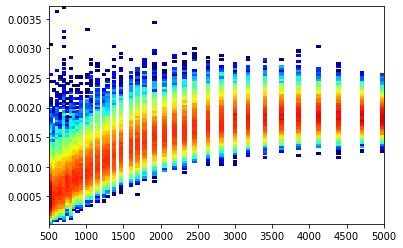

In [108]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(ell, ell * (ell + 1)* P, bins=100, cmap="jet", norm=LogNorm())

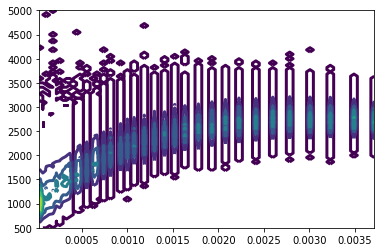

In [118]:
plt.contour(counts.T,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)

In [112]:
stds = data[ell_bins].std(axis=0)
mean = data[ell_bins].mean(axis=0)

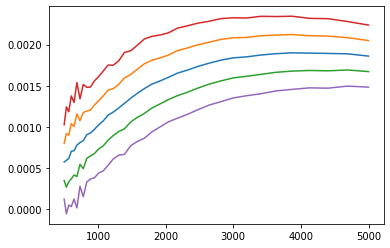

In [117]:
_ell = np.logspace(np.log10(500), np.log10(5000), 37)
plt.plot(_ell, _ell * (_ell + 1) * mean)
plt.plot(_ell, _ell * (_ell + 1) * (mean + stds))
plt.plot(_ell, _ell * (_ell + 1) * (mean - stds))
plt.plot(_ell, _ell * (_ell + 1) * (mean + 2*stds))
plt.plot(_ell, _ell * (_ell + 1) * (mean - 2*stds))